In [26]:
import os
import glob
from PIL import Image
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

In [69]:
pip install xformers

python(41538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached xformers-0.0.29.post3.tar.gz (8.5 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [194 lines of output]
      running bdist_wheel
      /opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:529: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
        warnings.warn(msg.format('we could not find ninja.'))
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.1-arm64-cpython-312
      creating build/lib.macosx-11.1-arm64-cpython-312/xformers
      copying xformers/_deprecation_warning.py -> build/lib.macosx-11.1-arm64-cpython-312/xformers
      copying xformers/attn_bias_utils.py -> build/lib.macosx-11.1-arm64-cpython-312/xformers
      copying xformers/checkpoint.py -> build/lib.macosx-11

In [27]:
dataset_path = "/Users/minhyeokroh/Documents/2025-1/DA_dataset/blendedMVS"

input_image_paths = sorted(glob.glob(os.path.join(dataset_path, "blended_images/*_masked.jpg")))
gt_image_paths = sorted(glob.glob(os.path.join(dataset_path, "rendered_depth_maps/*.pfm")))

# 이미지들을 저장할 리스트
# 변환 객체 생성 (이미지를 [0,1] 범위의 텐서로 변환)
to_tensor = transforms.Compose([
    transforms.CenterCrop(448),
    transforms.ToTensor(),
])

images = []
gt = []

# input 이미지: RGB 이미지로 변환 후 텐서화
for path in input_image_paths:
    try:
        img = Image.open(path).convert('RGB')
        tensor_img = to_tensor(img)
        images.append(tensor_img)
        print(f"Loaded image (tensor): {path}")
    except Exception as e:
        print(f"Error loading {path}: {e}")

# gt (depth map): 'F' 모드로 변환하여 텐서화
for path in gt_image_paths:
    try:
        img = Image.open(path).convert('F')
        tensor_img = to_tensor(img)
        gt.append(tensor_img)
        print(f"Loaded gt (tensor): {path}")
    except Exception as e:
        print(f"Error loading {path}: {e}")

print(f"총 {len(images)}개의 이미지, {len(gt)}개의 정답")

Loaded image (tensor): /Users/minhyeokroh/Documents/2025-1/DA_dataset/blendedMVS/blended_images/00000000_masked.jpg
Loaded image (tensor): /Users/minhyeokroh/Documents/2025-1/DA_dataset/blendedMVS/blended_images/00000001_masked.jpg
Loaded image (tensor): /Users/minhyeokroh/Documents/2025-1/DA_dataset/blendedMVS/blended_images/00000002_masked.jpg
Loaded image (tensor): /Users/minhyeokroh/Documents/2025-1/DA_dataset/blendedMVS/blended_images/00000003_masked.jpg
Loaded image (tensor): /Users/minhyeokroh/Documents/2025-1/DA_dataset/blendedMVS/blended_images/00000004_masked.jpg
Loaded image (tensor): /Users/minhyeokroh/Documents/2025-1/DA_dataset/blendedMVS/blended_images/00000005_masked.jpg
Loaded image (tensor): /Users/minhyeokroh/Documents/2025-1/DA_dataset/blendedMVS/blended_images/00000006_masked.jpg
Loaded image (tensor): /Users/minhyeokroh/Documents/2025-1/DA_dataset/blendedMVS/blended_images/00000007_masked.jpg
Loaded image (tensor): /Users/minhyeokroh/Documents/2025-1/DA_dataset/bl

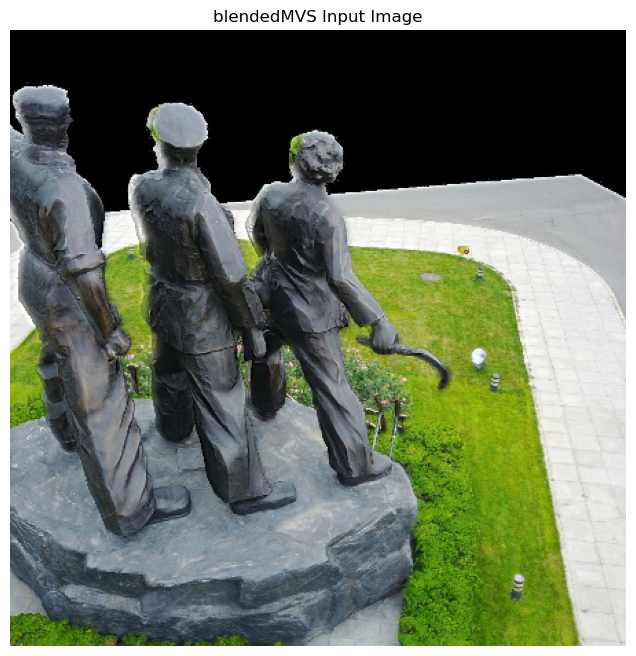

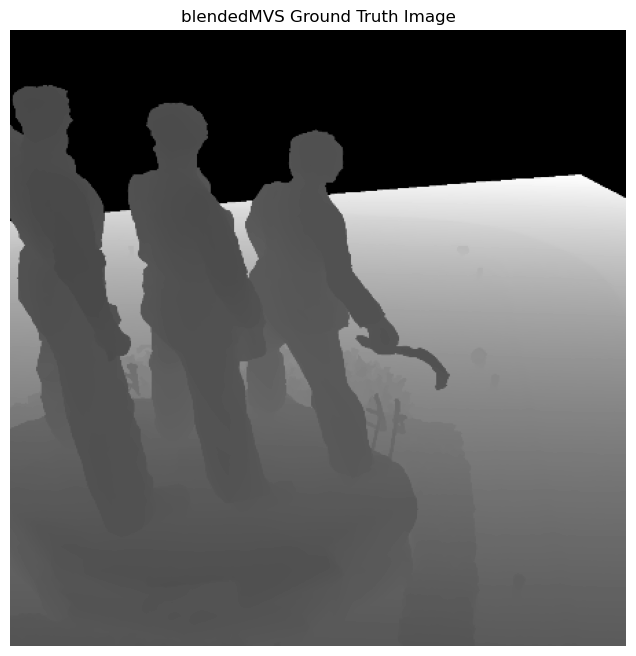

In [28]:
sample_idx = 32

# 입력 이미지 출력 (RGB: C x H x W → H x W x C)
if images and len(images) > sample_idx:
    img_tensor = images[sample_idx]
    # tensor shape (C, H, W) → (H, W, C)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title("blendedMVS Input Image")
    plt.axis("off")
    plt.show()
else:
    print("sample_idx에 해당하는 입력 이미지가 없습니다.")

# gt 출력 (depth map: 1채널, float → 2D array)
if gt and len(gt) > sample_idx:
    gt_tensor = gt[sample_idx]
    # gt tensor shape가 (1, H, W)라고 가정하고 squeeze하여 (H, W)로 변경
    gt_np = gt_tensor.squeeze(0).numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(gt_np, cmap="gray")
    plt.title("blendedMVS Ground Truth Image")
    plt.axis("off")
    plt.show()
else:
    print("sample_idx에 해당하는 gt 이미지가 없습니다.")

In [29]:
MVS_input = torch.stack(images)
MVS_gt = torch.stack(gt)

In [40]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(MVS_input, MVS_gt)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [41]:
# DataLoader에서 첫 배치만 꺼내서 확인
for batch in dataloader:
    inputs, targets = batch
    print("Input batch shape:", inputs.shape)
    print("GT batch shape:", targets.shape)
    break  # 첫 배치만 확인

Input batch shape: torch.Size([2, 3, 448, 448])
GT batch shape: torch.Size([2, 1, 448, 448])


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvUnit(nn.Module):
    """Residual Convolutional Unit"""
    def __init__(self, features, activation, bn):
        super().__init__()
        self.bn = bn
        self.conv1 = nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=True)
        if self.bn:
            self.bn1 = nn.BatchNorm2d(features)
            self.bn2 = nn.BatchNorm2d(features)
        self.activation = activation
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x):
        out = self.activation(x)
        out = self.conv1(out)
        if self.bn:
            out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        if self.bn:
            out = self.bn2(out)
        return self.skip_add.add(out, x)

class FeatureFusionBlock(nn.Module):
    """Feature Fusion Block"""
    def __init__(self, features, activation, deconv=False, bn=False, expand=False, align_corners=True, size=None):
        super().__init__()
        self.deconv = deconv
        self.align_corners = align_corners
        self.expand = expand
        out_features = features if not expand else features // 2
        self.out_conv = nn.Conv2d(features, out_features, kernel_size=1, stride=1, padding=0, bias=True)
        self.rcu1 = ResidualConvUnit(features, activation, bn)
        self.rcu2 = ResidualConvUnit(features, activation, bn)
        self.skip_add = nn.quantized.FloatFunctional()
        self.size = size

    def forward(self, *xs, size=None):
        output = xs[0]
        if len(xs) == 2:
            output = self.skip_add.add(output, self.rcu1(xs[1]))
        output = self.rcu2(output)
        modifier = {"scale_factor": 2} if (size is None and self.size is None) else {"size": size or self.size}
        output = F.interpolate(output, **modifier, mode="bilinear", align_corners=self.align_corners)
        output = self.out_conv(output)
        return output

def _make_fusion_block(features, use_bn, size=None):
    return FeatureFusionBlock(features, nn.ReLU(False), deconv=False, bn=use_bn, expand=False, align_corners=True, size=size)

def _make_scratch(in_shape, out_shape, groups=1, expand=False):
    scratch = nn.Module()
    # 각 레벨별 output 채널 (단순 구조 그대로)
    out_shape1, out_shape2, out_shape3 = out_shape, out_shape, out_shape
    if len(in_shape) >= 4:
        out_shape4 = out_shape
    if expand:
        out_shape1 = out_shape
        out_shape2 = out_shape * 2
        out_shape3 = out_shape * 4
        if len(in_shape) >= 4:
            out_shape4 = out_shape * 8
    scratch.layer1_rn = nn.Conv2d(in_shape[0], out_shape1, kernel_size=3, stride=1, padding=1, bias=False, groups=groups)
    scratch.layer2_rn = nn.Conv2d(in_shape[1], out_shape2, kernel_size=3, stride=1, padding=1, bias=False, groups=groups)
    scratch.layer3_rn = nn.Conv2d(in_shape[2], out_shape3, kernel_size=3, stride=1, padding=1, bias=False, groups=groups)
    if len(in_shape) >= 4:
        scratch.layer4_rn = nn.Conv2d(in_shape[3], out_shape4, kernel_size=3, stride=1, padding=1, bias=False, groups=groups)
    return scratch

# --- DPT Head 정의 ---
class DPTHead(nn.Module):
    def __init__(self, nclass, in_channels, features=256, use_bn=False, out_channels=[256, 512, 1024, 1024]):
        super().__init__()
        self.nclass = nclass

        # 각 레벨별로 1x1 conv로 채널 맞추기
        self.projects = nn.ModuleList([
            nn.Conv2d(in_channels, out_ch, kernel_size=1, stride=1, padding=0)
            for out_ch in out_channels
        ])

        # 업샘플링 레이어: transposed conv 또는 identity 사용
        self.resize_layers = nn.ModuleList([
            nn.ConvTranspose2d(out_channels[0], out_channels[0], kernel_size=4, stride=4, padding=0),
            nn.ConvTranspose2d(out_channels[1], out_channels[1], kernel_size=2, stride=2, padding=0),
            nn.Identity(),
            nn.Conv2d(out_channels[3], out_channels[3], kernel_size=3, stride=2, padding=1)
        ])

        # DPT의 scratch (refinement) 모듈
        self.scratch = _make_scratch(out_channels, features, groups=1, expand=False)
        self.scratch.refinenet1 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet2 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet3 = _make_fusion_block(features, use_bn)
        self.scratch.refinenet4 = _make_fusion_block(features, use_bn)

        # 출력 conv: 여기서는 depth map 예측 (nclass==1)
        self.scratch.output_conv1 = nn.Conv2d(features, features // 2, kernel_size=3, stride=1, padding=1)
        self.scratch.output_conv2 = nn.Sequential(
            nn.Conv2d(features // 2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True)
        )

    def forward(self, features, patch_h, patch_w):
        outs = []
        # features는 각 레벨에 대한 tensor 리스트, cls token 무시하고 첫번째만 사용
        for i, x in enumerate(features):
            # x의 첫번째 원소만 사용 (batch, seq, dim) → (batch, dim, patch_h, patch_w)
            x = x[0]
            x = x.permute(0, 2, 1).reshape(x.shape[0], x.shape[-1], patch_h, patch_w)
            x = self.projects[i](x)
            x = self.resize_layers[i](x)
            outs.append(x)
        layer1, layer2, layer3, layer4 = outs

        # scratch 모듈로 각 레벨 정제
        layer1_rn = self.scratch.layer1_rn(layer1)
        layer2_rn = self.scratch.layer2_rn(layer2)
        layer3_rn = self.scratch.layer3_rn(layer3)
        layer4_rn = self.scratch.layer4_rn(layer4)

        path4 = self.scratch.refinenet4(layer4_rn, size=layer3_rn.shape[2:])
        path3 = self.scratch.refinenet3(path4, layer3_rn, size=layer2_rn.shape[2:])
        path2 = self.scratch.refinenet2(path3, layer2_rn, size=layer1_rn.shape[2:])
        path1 = self.scratch.refinenet1(path2, layer1_rn)

        out = self.scratch.output_conv1(path1)
        # 임시 patch size에 맞춰 보간 → 최종 depth 해상도에 맞게 업샘플
        out = F.interpolate(out, (patch_h * 14, patch_w * 14), mode="bilinear", align_corners=True)
        out = self.scratch.output_conv2(out)
        return out

# --- DPT + DINOv2 Encoder ---
class DepthModel(nn.Module):
    def __init__(self, features=256, out_channels=[256, 512, 1024, 1024], use_bn=False, localhub=True):
        """
        encoder는 DINOv2 pretrained 모델
        DPT Head로 depth map 예측
        """
        super().__init__()
        # encoder: dino v2 vitb14 고정
        encoder = "vitb"
        if localhub:
            self.encoder = torch.hub.load(
                'torchhub/facebookresearch_dinov2_main',
                f'dinov2_{encoder}14',
                source='local',
                pretrained=True
            )
        else:
            self.encoder = torch.hub.load(
                'facebookresearch/dinov2',
                f'dinov2_{encoder}14'
            )

        # pretrained encoder의 첫 블록의 qkv in_features를 사용
        # 이거 실제 인풋이 아니라 채널만 맞춰주는 방식이야 !!
        in_channels = self.encoder.blocks[0].attn.qkv.in_features

        # DPT Head: depth map 예측 (nclass=1)
        self.head = DPTHead(1, in_channels, features, use_bn, out_channels=out_channels)

    def forward(self, x):
        h, w = x.shape[-2:]
        # encoder로부터 중간 레벨 feature 4개 추출
        features = self.encoder.get_intermediate_layers(x, 4, return_class_token=True)
        patch_h, patch_w = h // 14, w // 14
        depth = self.head(features, patch_h, patch_w)
        # 최종 해상도에 맞게 보간
        depth = F.interpolate(depth, size=(h, w), mode="bilinear", align_corners=True)
        depth = F.relu(depth)
        return depth.squeeze(1)

In [80]:
def teacher_loss_function(pred,y,disparity=True):
    """
    :param pred: Prediction per pixel. size : BxHxW
    :param y: Ground truth. size : BxHxW
    """
    B,H,W = pred.shape
    y = y.squeeze()

    print(pred.shape)
    print(y.shape)
    print("pred :",pred[0])

    eps = 1e-6

    if not disparity:
        ## 역수로 바꿔주기
        temp = torch.ones_like(y)
        y = temp/(y+eps)

    print("gt :",y[0])
    #pred = torch.reshape(pred,(B,H*W))
    #y = torch.reshape(y,(B,H*W))

    pred = pred.view(B, H * W)
    y = y.view(B, H * W)
    loss_l= 0


    def d_hat(d):
        # 각 배치별 계산을 위해 dim 설정
        # 여기서는 B x (HxW) 로 2차원이라고 가정
        median, _ = torch.median(d, dim=-1) # 이러면 나오는 결과 : Bx1
        # print(median)
        t = median.unsqueeze(-1)
        t = t.expand(-1,d.shape[-1])

        #t = torch.matmul(median.unsqueeze(0),t)
        s = torch.sum(torch.abs(d-t),dim=-1)/(d.shape[-1]) + eps
        # s : Bx1 사이즈

        s = s.unsqueeze(-1).expand(-1,d.shape[-1])

        #print("d : ",d)
        #print("t : ",t)
        #print("s : ",s)
        #print("분자 : ",torch.sum(d-t,dim=-1))

        return (d-t)/s

    def rho(pred,y):
        print("d_hat pred: ",d_hat(pred))
        print("d_hat y: ",d_hat(y))
        return torch.abs(d_hat(pred) - d_hat(y))

    loss_l = torch.sum(rho(pred,y),dim=-1) / pred.shape[-1]
    print(loss_l)

    return loss_l.mean()

In [81]:
if __name__ == '__main__':
    model = DepthModel(features=256, out_channels=[256, 512, 1024, 1024], use_bn=False, localhub=True)
    for name, param in model.state_dict().items():
        print(f"{name}:")
        print(param)
        print("="*50)

encoder.cls_token:
tensor([[[-6.9142e-04, -2.0539e-04, -4.6968e-02, -1.4960e-03, -2.0410e-02,
           4.7294e-03,  2.6455e-03, -4.9413e-03, -4.9912e-03, -1.1096e-03,
           2.4690e-03,  7.5610e-03,  7.1985e-03, -3.0513e-04, -3.3493e-03,
          -3.6020e-04,  1.2004e-02,  1.3525e-03, -1.4590e-02, -8.5887e-03,
          -7.0904e-04,  2.0706e-04, -1.8931e-03, -1.6581e-03, -1.7453e-03,
           1.5737e-03, -3.3249e-03, -3.5086e-04,  4.2582e-03, -6.0191e-03,
          -1.9831e-03,  3.4883e-04, -5.7279e-03,  3.4933e-02,  4.3051e-03,
           2.9389e-03, -9.7192e-04,  8.2199e-03,  3.6512e-03, -1.9048e-03,
           2.6950e-03, -4.7313e-02, -1.9887e-02, -7.3382e-04,  7.6832e-03,
          -2.8708e-02, -1.3646e-03, -1.8689e-04, -1.7721e-03, -4.0460e-03,
          -3.8712e-04,  8.3599e-03,  1.1057e-03, -2.7552e-03,  1.3896e-02,
          -2.5532e-03,  1.4683e-02, -3.9614e-03,  9.5134e-04,  3.6621e-03,
           3.0747e-04, -2.3839e-03, -1.7077e-03,  2.7554e-03,  2.9600e-03,
      

In [82]:
import torch
import torch.optim as optim
from tqdm import tqdm

# device 설정: CUDA 사용 가능하면 cuda, 아니면 cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model = DepthModel(features=256, out_channels=[256, 512, 1024, 1024], use_bn=False, localhub=True).to(device)
model.train()  # 학습 모드

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100
patient = 3
running_loss = 0.0
trial = 0

for epoch in range(num_epochs):
    prev_loss = running_loss
    running_loss = 0.0

    for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader)):
        # 입력 데이터도 device로 옮기기
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)  # outputs: (B, H, W)
        #print("inputs: ", inputs)
        #print("outputs: ", outputs)

        loss = teacher_loss_function(outputs, targets, disparity=False)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pth')
    print(f"Checkpoint saved for epoch {epoch+1}")

    if running_loss > prev_loss :
        if patient > trial:
            trial +=1
        else:
            break

cpu


0it [00:00, ?it/s]

torch.Size([2, 448, 448])
torch.Size([2, 448, 448])
pred : tensor([[0.0153, 0.0128, 0.0120,  ..., 0.0278, 0.0259, 0.0245],
        [0.0061, 0.0104, 0.0108,  ..., 0.0344, 0.0310, 0.0236],
        [0.0021, 0.0093, 0.0094,  ..., 0.0405, 0.0367, 0.0250],
        ...,
        [0.0243, 0.0264, 0.0221,  ..., 0.0390, 0.0369, 0.0300],
        [0.0262, 0.0325, 0.0320,  ..., 0.0402, 0.0383, 0.0307],
        [0.0233, 0.0307, 0.0305,  ..., 0.0270, 0.0287, 0.0232]],
       grad_fn=<SelectBackward0>)
gt : tensor([[0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0511],
        [0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0511],
        [0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0511, 0.0511],
        ...,
        [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
        [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
        [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515]])
d_hat pred:  tensor([[-1.2258, -1.4298, -1.4904,  ..., -0.2836, -0.1432, -0.5882],
        [-1.1682, -1.61

1it [00:08,  8.07s/it]

Epoch [1/5], Batch [0], Loss: 1.5238
torch.Size([2, 448, 448])
torch.Size([2, 448, 448])
pred : tensor([[0.0171, 0.0169, 0.0195,  ..., 0.0000, 0.0000, 0.0094],
        [0.0106, 0.0098, 0.0104,  ..., 0.0000, 0.0000, 0.0000],
        [0.0069, 0.0071, 0.0071,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0151, 0.0191, 0.0194,  ..., 0.0000, 0.0000, 0.0000],
        [0.0164, 0.0199, 0.0227,  ..., 0.0000, 0.0000, 0.0000],
        [0.0189, 0.0238, 0.0289,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<SelectBackward0>)
gt : tensor([[1.0000e+06, 1.0000e+06, 1.0000e+06,  ..., 1.0000e+06, 1.0000e+06,
         1.0000e+06],
        [1.0000e+06, 1.0000e+06, 1.0000e+06,  ..., 1.0000e+06, 1.0000e+06,
         1.0000e+06],
        [1.0000e+06, 1.0000e+06, 1.0000e+06,  ..., 1.0000e+06, 1.0000e+06,
         1.0000e+06],
        ...,
        [8.0419e-02, 8.0357e-02, 8.0266e-02,  ..., 7.4020e-02, 7.4045e-02,
         7.4067e-02],
        [8.0388e-02, 8.0373e-02, 8.0358e-02,  ..., 7.4157e-02, 7.4

1it [00:15, 15.74s/it]


KeyboardInterrupt: 